In [1]:
#what happens if we build a circuit variational template but with basis gates that are parameters
#I think the guess, and eval functions wil be messed up but we can start with that
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
sys.path.append("../../")
import numpy as np

# %matplotlib widget

In [2]:
from ast import Param
import src.utils.custom_gates as gates
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library.standard_gates import iSwapGate, CPhaseGate, RZGate, RXXGate
a = Parameter('a')
#RXXGate(a)
gates.RiSwapGate(a)
#RZGate(a)
#iSwapGate().power(1/a)
#CPhaseGate(a)

Instruction(name='riswap', num_qubits=2, num_clbits=0, params=[Parameter(a)])

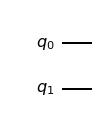

In [3]:
from src.basisv2 import CircuitTemplateV2
basis = CircuitTemplateV2(n_qubits=2, base_gates=[gates.RiSwapGate])
#basis.build(2)
basis.spanning_range = range(2,4)
basis.circuit.draw(output='mpl')

In [4]:
from src.cost_function import BasicCostInverse, BasicCost
objective1 = BasicCost()
objective2 = BasicCostInverse()
from src.optimizer import TemplateOptimizer
optimizer = TemplateOptimizer(basis=basis, objective=objective2, use_callback=True, override_fail=True)

In [5]:
from src.sampler import HaarSample
sampler = HaarSample(seed=0,n_samples=1)
s = [s for s in sampler][0]
ret = optimizer.approximate_target_U(s)

INFO:root:Begin search: (0.49741881, 0.30805173, 0.042267)
INFO:root:Starting opt on template size 2
INFO:root:Starting opt on template size 3
INFO:root:Loss=0.003160793000265838
INFO:root:Fail: (0.49741881, 0.30805173, 0.042267), Alternative: (0.49811252, 0.30889638, 0.04092587)


Decomposition Fidelity 0.9999910398055414
Circuit Fidelity 0.9968481389529049
Total Fidelity 0.9968392069997342


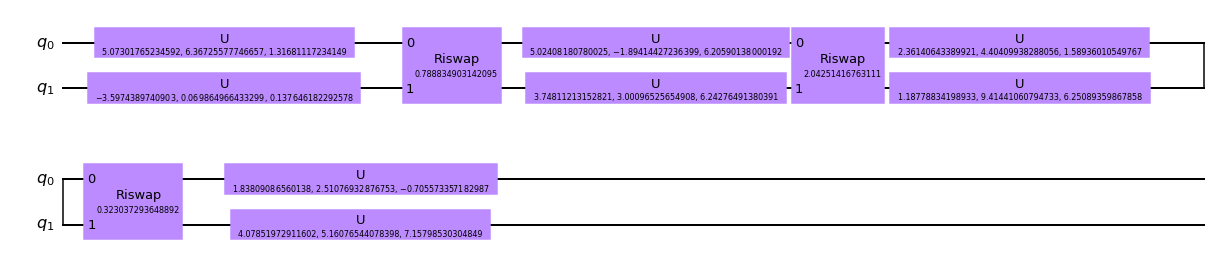

In [6]:
basis.build(ret.cycles)
circuit =basis.assign_Xk(ret.Xk)
print("Decomposition Fidelity", objective2.unitary_fidelity(basis.eval(ret.Xk), s))
print("Circuit Fidelity", basis.circuit_fidelity(ret.Xk))
print("Total Fidelity", 1-ret.loss_result)
circuit.draw(output='mpl')

In [20]:
#NOTE if use monodromy for 2Q case, can use cost function only relating to 2Q gate duration

In [33]:
#TODO: force setting to make 2Q params homogenous
#TODO: constraint each gate is less than .5, vs total gates less than 1.5

In [7]:
#can we use this circuit template to construct an entangled state
#1. we might define a new cost function that maximizes the entanglement (entropy-metric)
qc = QuantumCircuit(3)
qc.ry(2*np.arccos(1/np.sqrt(3)),0)
qc.ch(0,1)
qc.cx(1,2)
qc.cx(0,1)
qc.x(0)
from qiskit.quantum_info import Operator
w_state = Operator(qc).data
qc.draw()

┌────────────┐               ┌───┐
q_0: ┤ Ry(1.9106) ├──■─────────■──┤ X ├
     └────────────┘┌─┴─┐     ┌─┴─┐└───┘
q_1: ──────────────┤ H ├──■──┤ X ├─────
                   └───┘┌─┴─┐└───┘     
q_2: ───────────────────┤ X ├──────────
                        └───┘

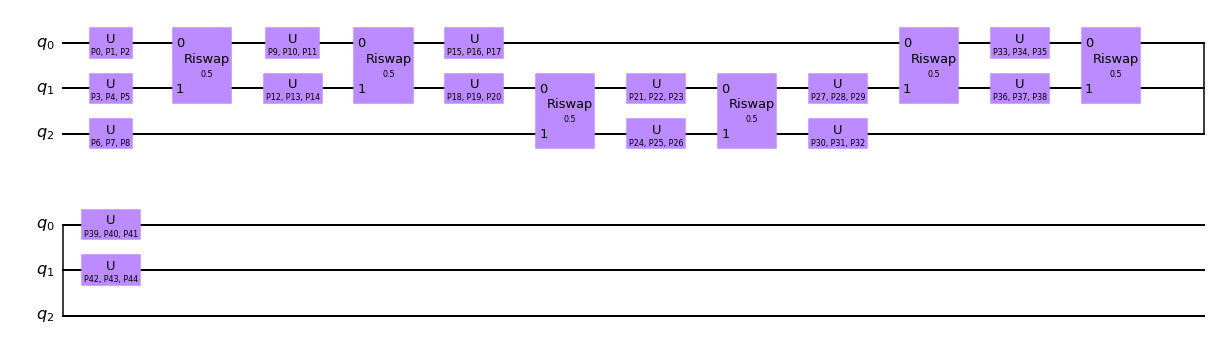

In [30]:
from src.basis import CircuitTemplate
basis1 = CircuitTemplate(n_qubits=3, base_gates=[gates.RiSwapGate(1/2)], edge_params=[[(0,1),  (0,1), (1,2), (1,2), (0,1), (0,1)]])
basis1.build(6)
basis1.spanning_range = range(6,7)
basis1.circuit.draw(output='mpl')

In [31]:
optimizer = TemplateOptimizer(basis=basis1, objective=objective1, use_callback=0, override_fail=True)
ret1 = optimizer.approximate_target_U(w_state)

INFO:root:Begin search: (-1, -1, -1, -1)
INFO:root:Starting opt on template size 6
INFO:root:Loss=5.506589295656283e-09


Decomposition Fidelity 0.9999999944934107
Total Fidelity 0.9999999944934107


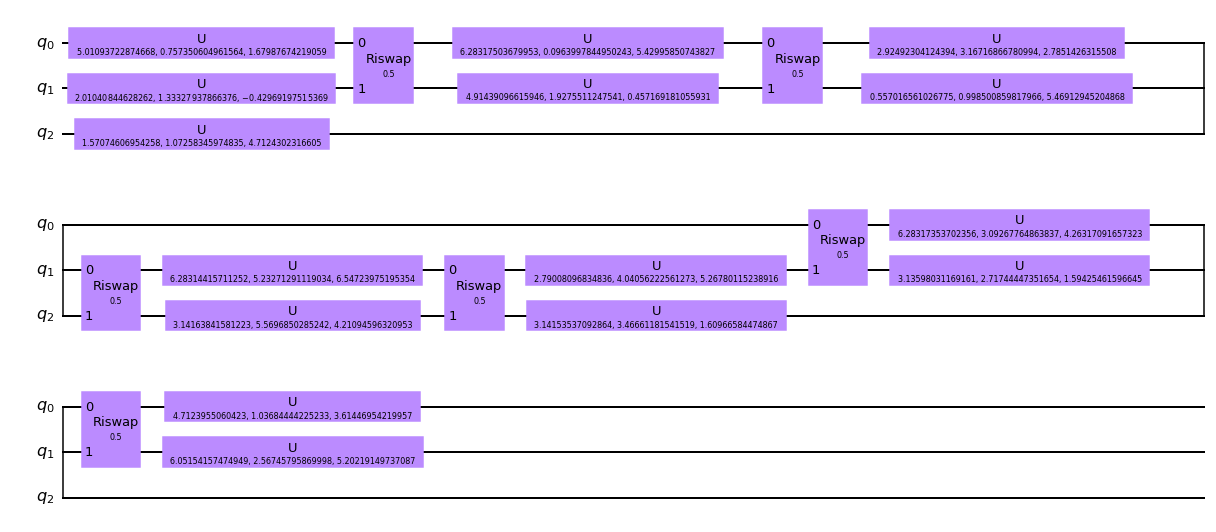

In [32]:
basis1.build(ret1.cycles)
circuit =basis1.assign_Xk(ret1.Xk)
print("Decomposition Fidelity", 1-objective1.unitary_fidelity(basis1.eval(ret1.Xk), w_state))
# print("Circuit Fidelity", basis.circuit_fidelity(ret.Xk))
print("Total Fidelity", 1-ret1.loss_result)
circuit.draw(output='mpl')

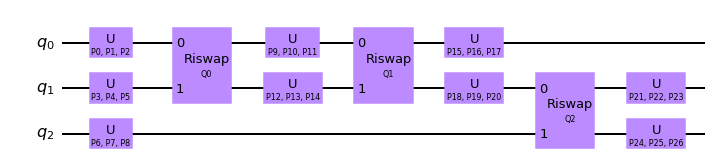

In [21]:
from src.basisv2 import CircuitTemplateV2
basis2 = CircuitTemplateV2(n_qubits=3, base_gates=[gates.RiSwapGate], edge_params=[[(0,1), (0,1), (1,2), (1,2), (0,2), (0,2)]])
basis2.build(3)
basis2.spanning_range = range(2,5)
basis2.circuit.draw(output='mpl')

In [12]:
optimizer = TemplateOptimizer(basis=basis2, objective=objective2, use_callback=True, override_fail=True)
ret2 = optimizer.approximate_target_U(w_state)

INFO:root:Begin search: (-1, -1, -1, -1)
INFO:root:Starting opt on template size 2
INFO:root:Starting opt on template size 3
INFO:root:Starting opt on template size 4
INFO:root:Loss=0.2639175680200879


Decomposition Fidelity 0.15598452940072557
Circuit Fidelity 0.9900408859811234
Total Fidelity 0.7360824319799121


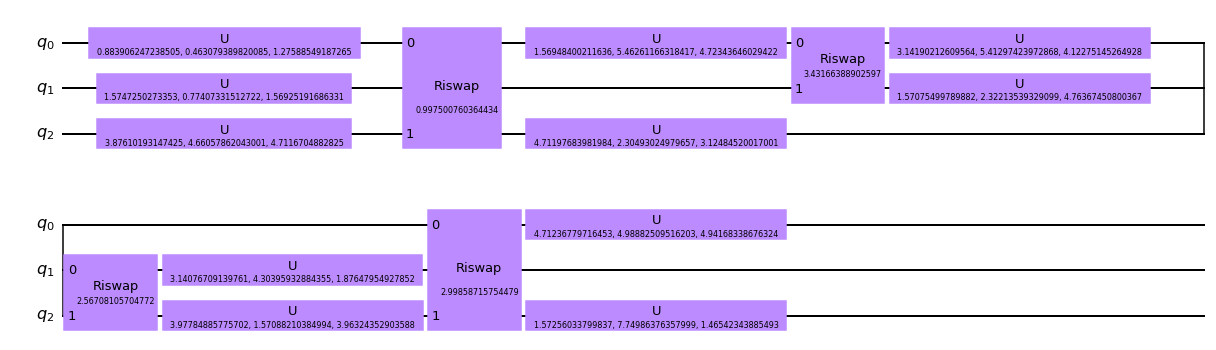

In [13]:
basis2.build(ret2.cycles)
circuit =basis2.assign_Xk(ret2.Xk)
print("Decomposition Fidelity", objective2.unitary_fidelity(basis2.eval(ret2.Xk), w_state))
print("Circuit Fidelity", basis2.circuit_fidelity(ret2.Xk))
print("Total Fidelity", 1-ret2.loss_result)
circuit.draw(output='mpl')

#### TODO
1. we need to modify the circuittemplate class so that each 2Q gate will be assigned its own parameter. If we create a second parameter vector separate from the 1Q parameters, it will be easier to handle.
2. We need to modify the cost function, using this new second parameter vector so that it knows to try and shrink the duration from the 2Q gates. We can modify the cost function using the NuOp cost function that looks like the product of decomposition fidelity and gate fidelity-I think this relies on needing a baseline iSWap fidelity.

Unfortunately, I think the best way to do this is to rewrite the entirety of the CircuitTemplate class....the key change should be to use 2 parameter vector classes, and just define a convention that the 1Q vector comes first.

For continuous parameters, we can't use monodromy. Maybe also we define a cost function, representing the circuit fidelity inside this class- so we don't have to pass around the 2Q parameter vector.

An epic goal would be to wrap the Hamiltonians in the custom cost gate class, then for an entangled unitary target (3Q) train over the hamiltonian parameters to minimize cost of circuit. If we use the 2Q gates we need to define an entanglement pattern, but if we give it an entire hamitlonian for 3Q simultanteously, I wonder if the circuit could train, fitting to the 2Q gate subclass as needed.